In [1]:
# Do not reload
import sys, os
sys.path.append("../")
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import DATA_PATH, MODELS_PATH
from src.common import input_keys, agg_trns, pickle_model_obj, unpickle_model_obj
from src.preprocess import Preprocessor
from src.model import ForestWrapper

%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv(DATA_PATH / 'generated_ad_data.csv.gz', sep=';', compression='gzip', parse_dates=[input_keys.TIME_KEY])
df.head()

,REQUEST_TIME,DEVICE_IP,DEVICE_IFA,GEO_CURRENT_CITY,DEVICE_LANGUAGE,GENERATED_AS_BOT
0,2022-12-21 02:30:48.180924,15.99.54.187,8e225a93-366f-44c8-9588-30f79c1910ae,Ramat Gan,en,0
1,2022-12-21 12:09:49.570128,15.99.54.187,8e225a93-366f-44c8-9588-30f79c1910ae,Ramat Gan,en,0
2,2022-12-21 12:59:56.963635,15.99.54.187,8e225a93-366f-44c8-9588-30f79c1910ae,Ramat Gan,en,0
3,2022-12-21 12:04:35.182955,15.99.54.187,8e225a93-366f-44c8-9588-30f79c1910ae,Ramat Gan,en,0
4,2022-12-21 12:18:46.331838,15.99.54.187,8e225a93-366f-44c8-9588-30f79c1910ae,Ramat Gan,en,0


In [4]:
preprocessor = Preprocessor(input_keys, agg_trns)
final_df = preprocessor.fit_transform(df)

pickle_model_obj(preprocessor, 'preprocessor.pkl')
    
final_df['BOT'] = df.groupby(input_keys.PRIMARY_KEY)['GENERATED_AS_BOT'].agg(min).values

D:\Data\Data Science\Interviews\Intelos\sleep-detector\sleep-detector\src\preprocess.py:101: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_feats.drop(columns=self.input_keys.PRIMARY_KEY)


After feature engineering:

In [5]:
final_df.head()

,DEVICE_IFA,0,1,2,3,4,5,6,7,8,...,CUMNORM_21,CUMNORM_22,"(TIME_DIFF, mean)","(TIME_DIFF, max)","(TIME_DIFF, min)","(TIME_DIFF, std)","(DEVICE_IP, nunique)","(GEO_CURRENT_CITY, nunique)","(DEVICE_LANGUAGE, nunique)",BOT
0,0002906e-f84b-4d64-9638-ddae29d504de,1.0,1.0,3.0,5.0,6.0,5.0,5.0,4.0,2.0,...,0.854167,0.885417,878.162177,8468.198092,0.326901,1788.252012,1,1,1,1
1,001e8498-c075-4448-b097-c7f430a82f29,47.0,11.0,21.0,10.0,11.0,15.0,17.0,14.0,7.0,...,0.650943,0.698113,272.171528,3428.526052,0.211989,471.465680,3,3,1,1
2,00219a4d-7c50-4f92-9b6a-2c45aa01da77,1.0,1.0,1.0,1.0,2.0,5.0,12.0,27.0,27.0,...,0.915254,0.915254,482.998852,6966.426071,0.015287,1386.179442,3,1,1,1
3,0022b697-b5db-4d43-bd94-054ffd10d1ee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,0.907407,0.962963,1089.697981,6634.434230,8.802567,1373.603377,2,1,1,0
4,0023f73f-14ec-4062-8908-3b89bf913938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.945946,1.000000,1564.527580,5314.931268,9.596043,1566.777868,1,1,1,0


# Visualizations

The average hourly activity profiles are different for bots and humans:

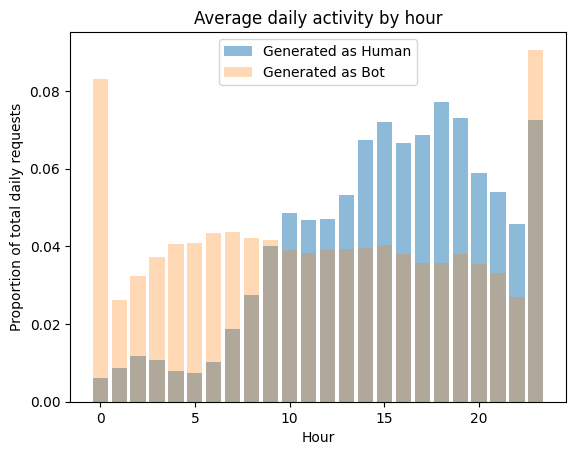

In [6]:
norm_df = final_df[[f'NORM_{i}' for i in range(24)]]

plt.title('Average daily activity by hour')
plt.bar(range(24), norm_df[final_df['BOT']==0].mean(axis=0), alpha=0.5, label='Generated as Human')
plt.bar(range(24), norm_df[final_df['BOT']==1].mean(axis=0), alpha=0.3, label='Generated as Bot')
plt.ylabel('Proportion of total daily requests')
plt.xlabel('Hour')
plt.legend()
plt.show()

Bots:
- have much less number of hours with zero activity;
- can have large total number of requests daily;
- have less average time difference between consecutive requests;
- have less variance (std) in the time difference between consecutive requests.

Illustrations:

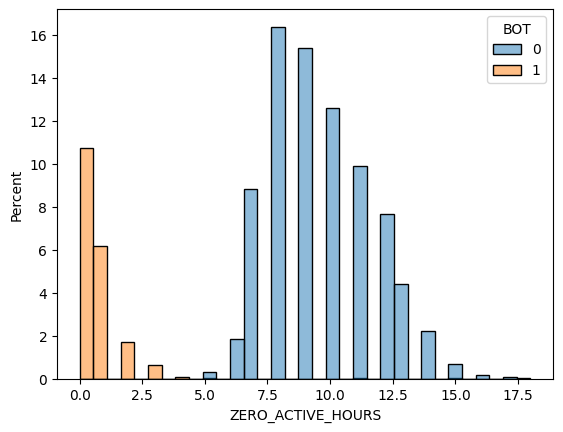

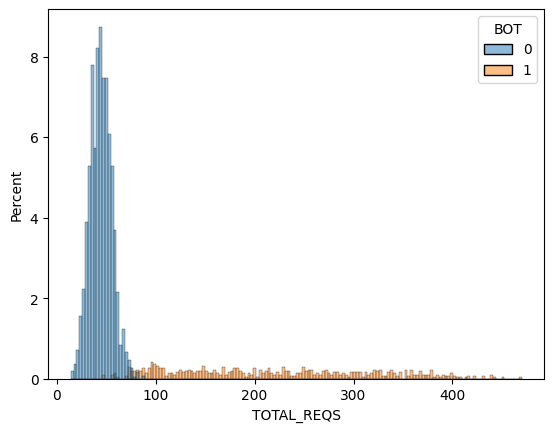

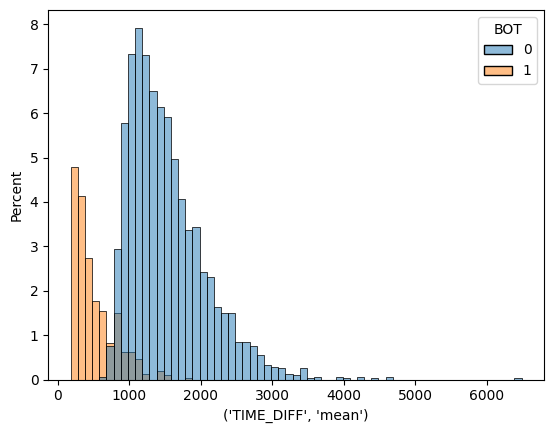

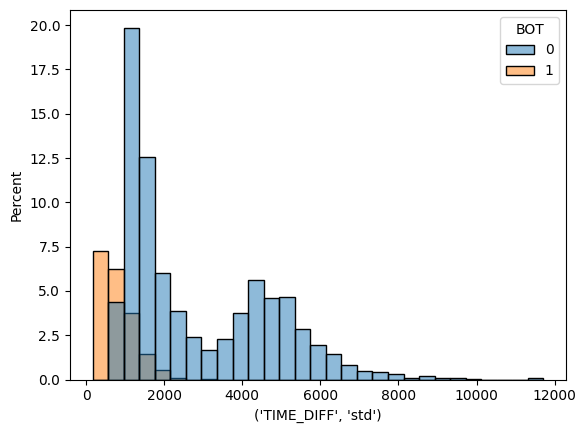

In [7]:
features = ['ZERO_ACTIVE_HOURS', 'TOTAL_REQS', ('TIME_DIFF', 'mean'), ('TIME_DIFF', 'std')]
for col in features:
    sns.histplot(x=final_df[col], hue=final_df['BOT'], stat='percent')
    plt.show()

Graphs provided above show that features produced can indeed be used to identify abnormal sleeping activity.

# Modelling

In [8]:
clf = ForestWrapper(n_estimators=300, contamination=0.2)
train_preds = clf.fit_predict(final_df.drop(columns=[input_keys.PRIMARY_KEY, 'BOT']))

pickle_model_obj(clf, 'forest.pkl')

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [9]:
print('Overall accuracy on train part:', ((train_preds < 0) == final_df['BOT']).mean())
print('Recall on train part:', (train_preds[final_df['BOT'] == 1] < 0).mean())
print('Precision on train part:', final_df[train_preds < 0]['BOT'].mean())

Overall accuracy on train part: 0.9370515329419439
Recall on train part: 0.8523489932885906
Precision on train part: 0.8287112561174551


# Checking on test data (generated by the same process):

In [10]:
test_df = pd.read_csv(
    DATA_PATH / 'generated_ad_data_test.csv.gz', sep=';', compression='gzip', parse_dates=[input_keys.TIME_KEY]
)
test_df.head()

,REQUEST_TIME,DEVICE_IP,DEVICE_IFA,GEO_CURRENT_CITY,DEVICE_LANGUAGE,GENERATED_AS_BOT
0,2022-12-21 00:38:50.539872,211.227.13.212,99cfaec5-808c-4bc9-aae6-9907dc5e1c55,Nazareth,he,1
1,2022-12-21 01:00:45.618857,222.125.81.24,99cfaec5-808c-4bc9-aae6-9907dc5e1c55,Nazareth,he,1
2,2022-12-21 02:55:30.504977,222.125.81.24,99cfaec5-808c-4bc9-aae6-9907dc5e1c55,Nazareth,he,1
3,2022-12-21 03:28:35.890054,211.227.13.212,99cfaec5-808c-4bc9-aae6-9907dc5e1c55,Nazareth,he,1
4,2022-12-21 04:47:44.640893,211.227.13.212,99cfaec5-808c-4bc9-aae6-9907dc5e1c55,Nazareth,he,1


In [11]:
preprocessor = unpickle_model_obj('preprocessor.pkl')
clf = unpickle_model_obj('forest.pkl')


final_test_df = preprocessor.transform(test_df)
final_test_df['BOT'] = test_df.groupby(input_keys.PRIMARY_KEY)['GENERATED_AS_BOT'].agg(min).values

D:\Data\Data Science\Interviews\Intelos\sleep-detector\sleep-detector\src\preprocess.py:101: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_feats.drop(columns=self.input_keys.PRIMARY_KEY)


In [12]:
test_preds = clf.predict(final_test_df.drop(columns=[input_keys.PRIMARY_KEY, 'BOT']))

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [13]:
print('Overall accuracy on test part:', ((test_preds < 0) == final_test_df['BOT']).mean())
print('Recall on test part:', (test_preds[final_test_df['BOT'] == 1] < 0).mean())
print('Precision on test part:', final_test_df[test_preds < 0]['BOT'].mean())

Overall accuracy on test part: 0.9224318658280922
Recall on test part: 0.8448275862068966
Precision on test part: 0.8376068376068376


# Visualize test performance

In [14]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans

In [15]:
tsne = TSNE(n_components=2, perplexity=35)
data_2d = tsne.fit_transform(final_test_df.drop(columns=[input_keys.PRIMARY_KEY]))

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


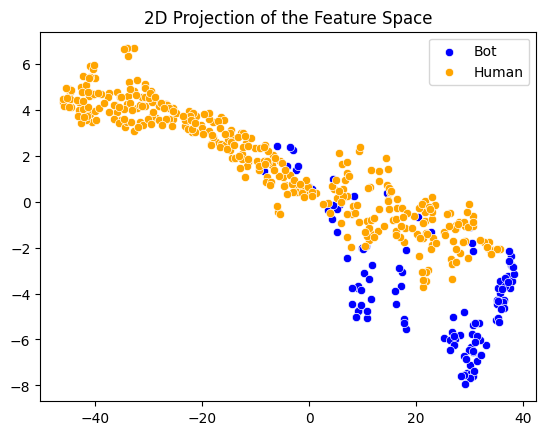

In [16]:
plt.title('2D Projection of the Feature Space')
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 1][:, 0], y=data_2d[final_test_df['BOT'] == 1][:, 1], color='blue', label='Bot'
)
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 0][:, 0], y=data_2d[final_test_df['BOT'] == 0][:, 1], color='orange', label='Human'
)
plt.legend()
plt.show()

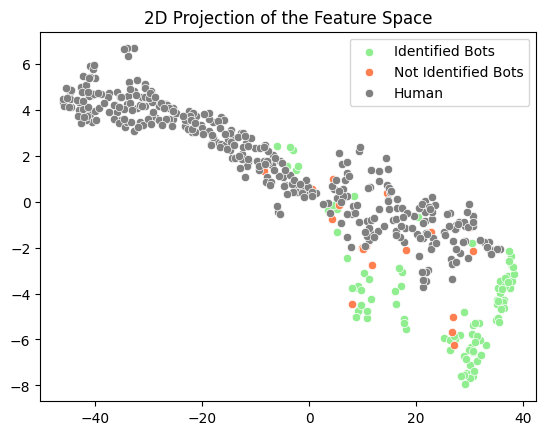

In [17]:
plt.title('2D Projection of the Feature Space')
sns.scatterplot(
    x=data_2d[(final_test_df['BOT'] == 1) & (test_preds < 0)][:, 0], y=data_2d[(final_test_df['BOT'] == 1) & (test_preds < 0)][:, 1], 
    color='lightgreen', label='Identified Bots')
sns.scatterplot(
    x=data_2d[(final_test_df['BOT'] == 1) & (test_preds >= 0)][:, 0], y=data_2d[(final_test_df['BOT'] == 1) & (test_preds >= 0)][:, 1], 
    color='coral', label='Not Identified Bots')
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 0][:, 0], y=data_2d[final_test_df['BOT'] == 0][:, 1], color='grey', label='Human'
)

plt.legend()
plt.show()